## In this document there was performed feature selection, feature engineering and training vs test error analysis for M1 (both own implmentation and sklearns)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error
from CDTR import CustomDecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor

In [ ]:
# loading the dataframe and performing 
df = pd.read_csv("data/claims_train.csv")
df = pd.get_dummies(df, drop_first=True, dtype=int)
df = df.drop(labels=["Area_B", "Area_C", "Area_D", "Area_E", "Area_F", "IDpol"], axis = 1)
df_clean = df[df["Exposure"] <= 1]
df_clean

Index(['ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus',
       'Density', 'VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12',
       'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3',
       'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular',
       'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25',
       'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43',
       'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93',
       'Region_R94'],
      dtype='object')

In [ ]:
# Defining our target variable
X = df_clean.drop("ClaimNb", axis = 1)
y = df_clean["ClaimNb"]

In [ ]:
# We convert the y pandas dataframe into a numpy array
y_array = y.to_numpy()

# Dividing the claims into two classes. 1 = claims above zero and 0 = having zero claims.
# This way we can include claims above zero in the fold.
y_class = np.where(y_array > 0, 1, 0)

In [ ]:
# Convert them to numpy arrays to make our model be able to process the data
X = X.to_numpy()
y = y.to_numpy()

In [ ]:
# We define our stratifiedKfold to include claims above 0 in every fold
skf = StratifiedKFold(n_splits=5)

In [ ]:
# Defining our new model with the fixed parameters we use for every evaluation
cdtr = CustomDecisionTreeRegressor(max_depth=8, min_samples_leafs=10)


In [ ]:
# Testing
score = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X,y_class)):
    print(f"Doing fold number {fold}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    cdtr.fit(X_train,y_train)

    y_pred = cdtr.predict(X_val)
    score.append(r2_score(y_pred=y_pred, y_true=y_val))



Doing fold number 0
Doing fold number 1
Doing fold number 2
Doing fold number 3
Doing fold number 4


In [ ]:
# Performance of our model with all the features
# R2 = 0.0305
np.mean(score)

np.float64(0.03049128574687221)

### Calculating the permutation score for each feature

In [ ]:
# initialising a list to store all the importances scores for each feature for each fold
fold_importance = []

# looping through each fold
for fold, (train_idx, val_idx) in enumerate(skf.split(X,y_class)):
    print(f"Doing fold number {fold}")

    # Indexing the correct datapoint for the fold
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Fitting the data
    cdtr.fit(X_train,y_train)

    # Calculating the importance score for each feature in this fold
    r = permutation_importance(
        cdtr,
        X_val,
        y_val,
        n_repeats=10,
        scoring="neg_mean_squared_error",
        random_state=42 + fold,
        n_jobs=-1
    )

    # Add importances to the list
    fold_importance.append(r.importances_mean)

Doing fold number 0
Doing fold number 1
Doing fold number 2
Doing fold number 3
Doing fold number 4


In [32]:
fold_importance

[array([ 2.48284783e-03,  5.27651650e-04,  1.07602659e-03,  5.63745914e-04,
         2.53440253e-03, -9.22549858e-06,  0.00000000e+00,  0.00000000e+00,
         7.08730462e-04,  0.00000000e+00,  7.47730288e-06,  0.00000000e+00,
         4.29734611e-07,  0.00000000e+00, -1.02759395e-06, -7.97305403e-06,
         3.88884654e-04,  4.67529586e-06,  0.00000000e+00,  5.05904227e-06,
         4.24067564e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.77645069e-07, -8.46159044e-06, -1.50506609e-06,  1.07821453e-06,
         8.53744878e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.16284568e-06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.88498203e-06]),
 array([ 2.61606728e-03,  5.81064277e-04,  1.45589820e-03,  6.69572498e-04,
         2.55490862e-03,  5.53816661e-05,  1.27860493e-05,  1.89196178e-06,
         9.65449470e-04,  2.01654176e-05,  0.00000000e+00, -3.86321285e-06,
         0.00000000e+00,  0.00000000e+00, -8

In [ ]:
# Creating a pandas dataframe to store all the data of the feature importance
fold_importance = np.array(fold_importance)
mean_importance = fold_importance.mean(axis=0)
std_importance = fold_importance.std(axis=0)

X_importance = df_clean.drop("ClaimNb", axis = 1)

feature_importance_skf = (pd.DataFrame({
        "feature": X_importance.columns,
        "importance": mean_importance,
        "std": std_importance
    }).sort_values("importance", ascending=False))

In [34]:
feature_importance_skf

,feature,importance,std
4,BonusMalus,2.599048e-03,1.210267e-04
0,Exposure,2.407633e-03,1.892780e-04
2,VehAge,1.326805e-03,1.424070e-04
8,VehBrand_B12,9.077008e-04,1.027331e-04
3,DrivAge,6.888876e-04,9.197255e-05
1,VehPower,5.623513e-04,2.258002e-05
16,VehGas_Regular,4.815010e-04,6.872749e-05
5,Density,2.515077e-05,2.952203e-05
32,Region_R74,1.166219e-05,2.363461e-05
28,Region_R53,1.144618e-05,1.606591e-05


In [ ]:
# Saving the result in a csv
feature_importance_skf.to_csv("feature_importance_skf.csv")

In [ ]:
# Only choosing features with an importance score above 0
selected_features = feature_importance_skf[feature_importance_skf["importance"] > 0]["feature"]

In [37]:
selected_features.values

array(['BonusMalus', 'Exposure', 'VehAge', 'VehBrand_B12', 'DrivAge',
       'VehPower', 'VehGas_Regular', 'Density', 'Region_R74',
       'Region_R53', 'Region_R24', 'VehBrand_B13', 'VehBrand_B6',
       'VehBrand_B10', 'Region_R54', 'Region_R82', 'Region_R22',
       'VehBrand_B11', 'Region_R25', 'Region_R23', 'Region_R94',
       'VehBrand_B14', 'Region_R31', 'Region_R91', 'Region_R41',
       'Region_R72'], dtype=object)

### Shrinking the amount of features by one through each iteration to see the optimal combination of features for a good model.

In [ ]:
model_results = []
num_of_features = []

for i in range(len(selected_features)):
    print(f"Doing {26-i} features")

    fold_scores = []

    # Shrinking the data by i each time
    X = df_clean[selected_features.values[0:25-i]]

    for fold, (train_idx, val_idx) in enumerate(skf.split(X,y_class)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        X_train = X_train.to_numpy()
        X_val = X_val.to_numpy()
        y_train, y_val = y[train_idx], y[val_idx]

        cdtr.fit(X_train,y_train)
        y_pred = cdtr.predict(X_val)

        fold_scores.append(r2_score(y_val, y_pred))
    
    model_results.append(np.mean(fold_scores))
    num_of_features.append(26-i)
        


Doing 26 features
Doing 25 features
Doing 24 features
Doing 23 features
Doing 22 features
Doing 21 features
Doing 20 features
Doing 19 features
Doing 18 features
Doing 17 features
Doing 16 features
Doing 15 features
Doing 14 features
Doing 13 features
Doing 12 features
Doing 11 features
Doing 10 features
Doing 9 features
Doing 8 features
Doing 7 features
Doing 6 features
Doing 5 features
Doing 4 features
Doing 3 features
Doing 2 features
Doing 1 features


In [ ]:
# Creating pandas dataframe with results
feature_shrinking = (pd.DataFrame({
        "Number of features": num_of_features,
        "R_squared": model_results,
    })
    .sort_values("R_squared", ascending=False))

In [42]:
feature_shrinking

,Number of features,R_squared
18,8,3.185623e-02
13,13,3.124459e-02
14,12,3.122349e-02
15,11,3.112825e-02
16,10,3.111873e-02
17,9,3.109223e-02
12,14,3.101805e-02
11,15,3.098738e-02
10,16,3.095797e-02
1,25,3.070536e-02


In [ ]:
# Saving the results as csv
feature_shrinking.to_csv("feature_shrinking.csv")

In [ ]:
# Dataframe with the first 8 features
optimized_df = df_clean[selected_features.values[0:8]]

In [45]:
optimized_df

,BonusMalus,Exposure,VehAge,VehBrand_B12,DrivAge,VehPower,VehGas_Regular,Density
0,95,0.43,18,0,36,7,1,1054
1,95,0.10,17,0,80,7,1,598
2,76,0.33,3,0,36,7,1,4172
3,52,0.56,4,0,73,5,0,15
4,50,0.27,0,0,37,8,0,3021
...,...,...,...,...,...,...,...,...
542405,76,0.20,10,0,32,6,0,1314
542406,60,0.06,14,0,34,10,0,685
542407,95,0.34,8,0,32,6,0,242
542408,72,0.72,7,0,39,9,1,3301


### Feature engineering

In [ ]:
# Getting names for feature engineering
combi_features = selected_features.values[0:8]
combi_features

In [52]:
moost_important_features = selected_features.values[0:8]

In [ ]:
# Adding features together to see if an improvement happens.

combi = optimized_df.copy()
combination_names = []
r2_scores = []
std_scores = []
cross_valid = []
mean_r2 = []

for i in range(len(combi_features)):
    for n in range(len(combi_features) - i):
        fold_scores_combi = []
        if i == n:
            continue
        else:
            combination = combi_features[i] + " and " + combi_features[i+n]
            combination_names.append(combination)

            #Adding the features together
            combi["Combi"] = combi[combi_features[i]] + combi[combi_features[i+n]]
            print(f"Doing combination {combination}")

            # Testing the newly created feature
            for fold, (train_idx, val_idx) in enumerate(skf.split(X = np.array(combi),y=y_class)):
                print(f"Doing fold {fold}")
                X_train, X_val = combi.iloc[train_idx], combi.iloc[val_idx]
                X_train = X_train.to_numpy()
                X_val = X_val.to_numpy()
                y_train, y_val = y[train_idx], y[val_idx]

                cdtr.fit(X_train,y_train)
                y_pred = cdtr.predict(X_val)
                fold_scores_combi.append(r2_score(y_val, y_pred))
            
        
        mean_r2.append(np.mean(fold_scores_combi))
            

addition = (pd.DataFrame({
        "feature combination": combination_names,
        "R_squared": mean_r2,
    }).sort_values("R_squared", ascending=False))


Doing combination BonusMalus and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and DrivAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehPower
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehGas_Regular
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and Density
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and 

In [58]:
addition

,feature combination,R_squared
20,VehBrand_B12 and VehPower,0.031413
9,Exposure and DrivAge,0.031256
23,DrivAge and VehPower,0.031249
19,VehBrand_B12 and DrivAge,0.031205
16,VehAge and VehGas_Regular,0.031155
8,Exposure and VehBrand_B12,0.031111
6,BonusMalus and Density,0.031106
21,VehBrand_B12 and Density,0.031100
13,VehAge and VehAge,0.031092
29,VehGas_Regular and VehGas_Regular,0.031092


In [ ]:
# Multiplying features

combi = optimized_df.copy()
combination_names = []
r2_scores = []
std_scores = []
cross_valid = []
mean_r2 = []

for i in range(len(combi_features)):
    for n in range(len(combi_features) - i):
        fold_scores_combi = []
        if i == n:
            continue
        else:
            combination = combi_features[i] + " and " + combi_features[i+n]
            combination_names.append(combination)
            combi["Combi"] = combi[combi_features[i]] * combi[combi_features[i+n]]
            print(f"Doing combination {combination}")

            for fold, (train_idx, val_idx) in enumerate(skf.split(X = np.array(combi),y=y_class)):
                print(f"Doing fold {fold}")
                X_train, X_val = combi.iloc[train_idx], combi.iloc[val_idx]
                X_train = X_train.to_numpy()
                X_val = X_val.to_numpy()
                y_train, y_val = y[train_idx], y[val_idx]

                cdtr.fit(X_train,y_train)
                y_pred = cdtr.predict(X_val)
                fold_scores_combi.append(r2_score(y_val, y_pred))
            
        
        mean_r2.append(np.mean(fold_scores_combi))
            

multiplication = (pd.DataFrame({
        "feature combination": combination_names,
        "R_squared": mean_r2,})
        .sort_values("R_squared", ascending=False))


Doing combination BonusMalus and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and DrivAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehPower
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehGas_Regular
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and Density
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and 

In [63]:
multiplication

,feature combination,R_squared
20,VehBrand_B12 and VehPower,0.031798
23,DrivAge and VehPower,0.031666
8,Exposure and VehBrand_B12,0.031421
3,BonusMalus and DrivAge,0.031392
16,VehAge and VehGas_Regular,0.031265
6,BonusMalus and Density,0.031218
27,VehPower and VehGas_Regular,0.031172
24,DrivAge and VehGas_Regular,0.031126
13,VehAge and VehAge,0.031092
29,VehGas_Regular and VehGas_Regular,0.031092


In [ ]:
# Dividing features with eachother

combi = optimized_df.copy()

# Initialising different list to keep track of scores
combination_names = []
r2_scores = []
std_scores = []
cross_valid = []
mean_r2 = []

# Looping through every combination
for i in range(len(combi_features)):
    for n in range(len(combi_features) - i):
        fold_scores_combi = []
        if i == n:
            continue
        else:
            combination = combi_features[i] + " and " + combi_features[i+n]
            combination_names.append(combination)

            combi["Combi"] = combi[combi_features[i]] / (combi[combi_features[i+n]] + 0.000000001)
            print(f"Doing combination {combination}")

            for fold, (train_idx, val_idx) in enumerate(skf.split(X = np.array(combi),y=y_class)):
                print(f"Doing fold {fold}")
                X_train, X_val = combi.iloc[train_idx], combi.iloc[val_idx]
                X_train = X_train.to_numpy()
                X_val = X_val.to_numpy()
                y_train, y_val = y[train_idx], y[val_idx]

                cdtr.fit(X_train,y_train)
                y_pred = cdtr.predict(X_val)
                fold_scores_combi.append(r2_score(y_val, y_pred))
            
        
        mean_r2.append(np.mean(fold_scores_combi))

division = (pd.DataFrame({
        "feature combination": combination_names,
        "R_squared": mean_r2,
    }).sort_values("R_squared", ascending=False))

Doing combination BonusMalus and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and DrivAge
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehPower
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and VehGas_Regular
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination BonusMalus and Density
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and Exposure
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and VehBrand_B12
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing combination Exposure and 

In [65]:
division

,feature combination,R_squared
20,VehBrand_B12 and VehPower,0.031691
1,BonusMalus and VehAge,0.031272
14,VehAge and VehBrand_B12,0.031201
6,BonusMalus and Density,0.031188
3,BonusMalus and DrivAge,0.031184
5,BonusMalus and VehGas_Regular,0.031144
13,VehAge and VehAge,0.031092
18,VehBrand_B12 and VehBrand_B12,0.031092
22,DrivAge and DrivAge,0.031092
31,Density and Density,0.031092


In [67]:
importantFeatures = (pd.DataFrame({"feature": moost_important_features}))
importantFeatures

,feature
0,BonusMalus
1,Exposure
2,VehAge
3,VehBrand_B12
4,DrivAge
5,VehPower
6,VehGas_Regular
7,Density


In [ ]:
BestFeatures = df_clean[moost_important_features]

In [ ]:
# Saving all the results to csv
addition.to_csv("addition_combination_results.csv")
multiplication.to_csv("multiplication_combination_results.csv")
division.to_csv("division_combination_results.csv")
importantFeatures.to_csv("importantFeatures.csv")
BestFeatures.to_csv("optimized_data.csv")

### Looking at the test and training error to find optimal parameter to avoid overfitting or underfitting

#### Looking at the relation between test and training error for max depth

Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4


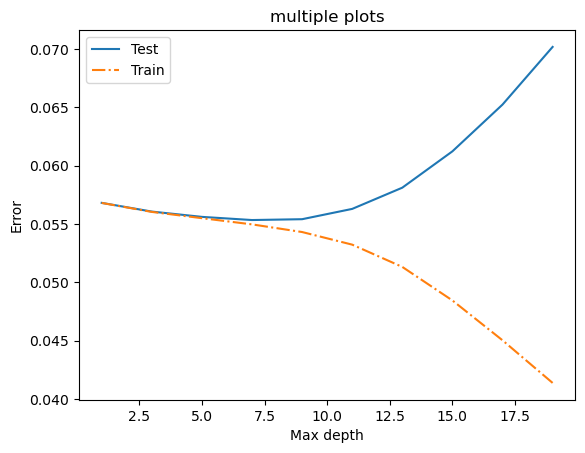

In [ ]:
# Defining the range of the value the parameter will go through
start_value = 1
end_value = 20
index = 2

x_graph = list(range(start_value, end_value,index))

y_graph_test = []
y_graph_train = []

X2 = np.array(BestFeatures)

for parameter in range(start_value,end_value,index):
    model = CustomDecisionTreeRegressor(max_depth=parameter, min_samples_leafs=10)

    fold_test = []
    fold_train = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X = X2,y=y_class)):
        X_train, X_val = X2[train_idx], X2[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train,y_train)
    
        y_pred_test = model.predict(X_val)
        y_pred_train = model.predict(X_train)

        fold_test.append(mean_squared_error(y_pred=y_pred_test, y_true=y_val))
        fold_train.append(mean_squared_error(y_pred=y_pred_train, y_true=y_train))


    train_score = np.mean(fold_train)
    test_score = np.mean(fold_test)


    y_graph_test.append(test_score)
    y_graph_train.append(train_score)

plt.plot(x_graph, y_graph_test, label ='Test')
plt.plot(x_graph, y_graph_train, '-.', label ='Train')

plt.xlabel("Max depth")
plt.ylabel("Error")
plt.legend()
plt.title('multiple plots')
plt.show()

# We can see that optimal max_depth is 8 as we can see the starts to overfit after 8.

#### Looking at the minimum samples in leaf

Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4


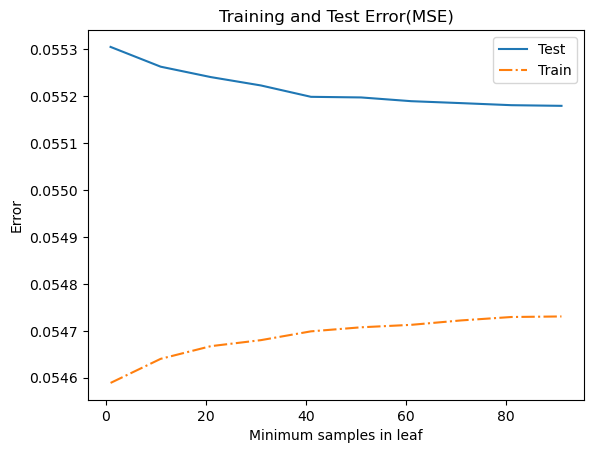

In [ ]:
start_value = 1
end_value = 101
index = 10
x_graph = list(range(start_value, end_value,index))
y_graph_test = []
y_graph_train = []

X2 = np.array(df_clean[moost_important_features])

for parameter in range(start_value,end_value,index):
    model = CustomDecisionTreeRegressor(max_depth=8, min_samples_leafs=parameter)

    fold_test = []
    fold_train = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X = X2,y=y_class)):
        print(f"Doing fold {fold}")
        X_train, X_val = X2[train_idx], X2[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train,y_train)
    
        y_pred_test = model.predict(X_val)
        y_pred_train = model.predict(X_train)

        fold_test.append(mean_squared_error(y_pred=y_pred_test, y_true=y_val))
        fold_train.append(mean_squared_error(y_pred=y_pred_train, y_true=y_train))


    train_score = np.mean(fold_train)
    test_score = np.mean(fold_test)


    y_graph_test.append(test_score)
    y_graph_train.append(train_score)

plt.plot(x_graph, y_graph_test, label ='Test')
plt.plot(x_graph, y_graph_train, '-.', label ='Train')

plt.xlabel("Minimum samples in leaf")
plt.ylabel("Error")
plt.legend()
plt.title('Training and Test Error(MSE)')
plt.show()

# Minimum number of samples in leaf 40

#### Looking if the trend continues afterwards and just stagnates

Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4
Doing fold 0
Doing fold 1
Doing fold 2
Doing fold 3
Doing fold 4


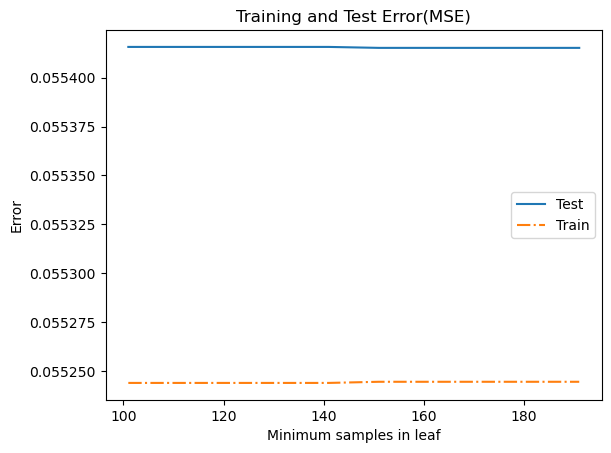

In [ ]:
start_value = 101
end_value = 201
index = 10
x_graph = list(range(start_value, end_value,index))
y_graph_test = []
y_graph_train = []

X2 = np.array(df_clean[moost_important_features])

for parameter in range(start_value,end_value,index):
    model = CustomDecisionTreeRegressor(max_depth=6, min_samples_leafs=parameter)

    fold_test = []
    fold_train = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X = X2,y=y_class)):
        print(f"Doing fold {fold}")
        X_train, X_val = X2[train_idx], X2[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model.fit(X_train,y_train)
    
        y_pred_test = model.predict(X_val)
        y_pred_train = model.predict(X_train)

        fold_test.append(mean_squared_error(y_pred=y_pred_test, y_true=y_val))
        fold_train.append(mean_squared_error(y_pred=y_pred_train, y_true=y_train))


    train_score = np.mean(fold_train)
    test_score = np.mean(fold_test)


    y_graph_test.append(test_score)
    y_graph_train.append(train_score)

plt.plot(x_graph, y_graph_test, label ='Test')
plt.plot(x_graph, y_graph_train, '-.', label ='Train')

plt.xlabel("Minimum samples in leaf")
plt.ylabel("Error")
plt.legend()
plt.title('Training and Test Error(MSE)')
plt.show()

# We can see that it stagnates 

In [76]:
finalModel = CustomDecisionTreeRegressor(max_depth=8, min_samples_leafs=40)

In [79]:
score = []

X2 = np.array(df_clean[moost_important_features])


for fold, (train_idx, val_idx) in enumerate(skf.split(X2,y_class)):
    print(f"Doing fold number {fold}")
    X_train, X_val = X2[train_idx], X2[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    finalModel.fit(X_train,y_train)

    y_pred = finalModel.predict(X_val)
    score.append(r2_score(y_pred=y_pred, y_true=y_val))

Doing fold number 0
Doing fold number 1
Doing fold number 2
Doing fold number 3
Doing fold number 4


In [81]:
np.mean(score)

np.float64(0.03221838827519359)

In [83]:
regressor = DecisionTreeRegressor(max_depth=8, min_samples_leaf=40)

In [ ]:
score_sklearn = []

X2 = np.array(df_clean[moost_important_features])


for fold, (train_idx, val_idx) in enumerate(skf.split(X2,y_class)):
    print(f"Doing fold number {fold}")
    X_train, X_val = X2[train_idx], X2[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]


    regressor.fit(X_train,y_train)

    y_pred = finalModel.predict(X_val)
    score_sklearn.append(r2_score(y_pred=y_pred, y_true=y_val))

np.mean(score_sklearn)

# Got an R2 score of: 0.03828260811024249

Doing fold number 0
Doing fold number 1
Doing fold number 2
Doing fold number 3
Doing fold number 4


### Looking at test vs training error for sklearn implmentation

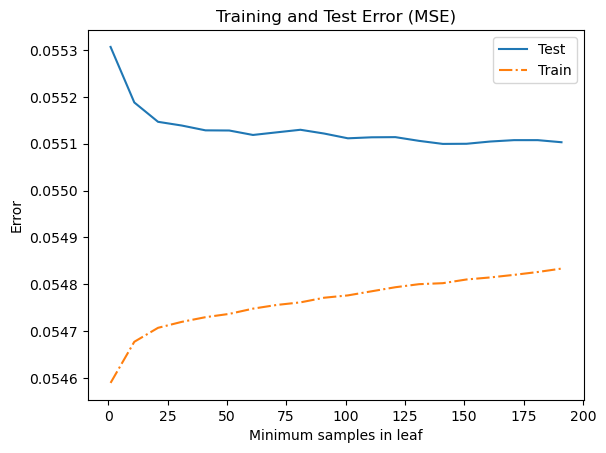

In [ ]:
start_value = 1
end_value = 101
index = 10
x_graph = list(range(start_value, end_value,index))
y_graph_test = []
y_graph_train = []

X2 = np.array(df_clean[moost_important_features])

for parameter in range(start_value,end_value,index):
    model_sklearn = DecisionTreeRegressor(max_depth=8, min_samples_leaf=parameter)

    fold_test = []
    fold_train = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X = X2,y=y_class)):
        X_train, X_val = X2[train_idx], X2[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model_sklearn.fit(X_train,y_train)
    
        y_pred_test = model_sklearn.predict(X_val)
        y_pred_train = model_sklearn.predict(X_train)

        fold_test.append(mean_squared_error(y_pred=y_pred_test, y_true=y_val))
        fold_train.append(mean_squared_error(y_pred=y_pred_train, y_true=y_train))


    train_score = np.mean(fold_train)
    test_score = np.mean(fold_test)


    y_graph_test.append(test_score)
    y_graph_train.append(train_score)

plt.plot(x_graph, y_graph_test, label ='Test')
plt.plot(x_graph, y_graph_train, '-.', label ='Train')

plt.xlabel("Minimum samples in leaf")
plt.ylabel("Error")
plt.legend()
plt.title('Training and Test Error (MSE)')
plt.show()

# Minimum number of samples in leaf 40

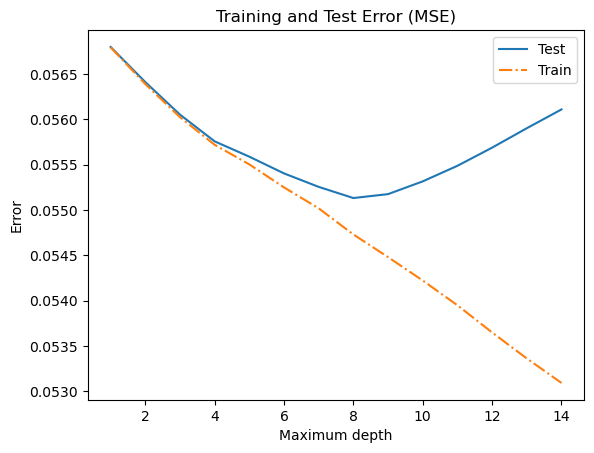

In [108]:
start_value = 1
end_value = 15
index = 1
x_graph = list(range(start_value, end_value,index))
y_graph_test = []
y_graph_train = []

X2 = np.array(df_clean[moost_important_features])

for parameter in range(start_value,end_value,index):
    model_sklearn = DecisionTreeRegressor(max_depth=parameter, min_samples_leaf=40)

    fold_test = []
    fold_train = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X = X2,y=y_class)):
        X_train, X_val = X2[train_idx], X2[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model_sklearn.fit(X_train,y_train)
    
        y_pred_test = model_sklearn.predict(X_val)
        y_pred_train = model_sklearn.predict(X_train)

        fold_test.append(mean_squared_error(y_pred=y_pred_test, y_true=y_val))
        fold_train.append(mean_squared_error(y_pred=y_pred_train, y_true=y_train))


    train_score = np.mean(fold_train)
    test_score = np.mean(fold_test)


    y_graph_test.append(test_score)
    y_graph_train.append(train_score)

plt.plot(x_graph, y_graph_test, label ='Test')
plt.plot(x_graph, y_graph_train, '-.', label ='Train')

plt.xlabel("Maximum depth")
plt.ylabel("Error")
plt.legend()
plt.title('Training and Test Error (MSE)')
plt.show()

# Minimum number of samples in leaf 40